# Chapter 1

First, we download and parse the Archive II dataset.

## Downloader

In [27]:
import requests
import tarfile
import os

def downloader(url, output_dir):
    """
    Downloads a tar.gz file from the specified URL, extracts its contents into a 
    given directory, and removes the downloaded file.

    Parameters:
        url (str): The URL of the tar.gz file to download.
        output_dir (str): The directory where the contents will be extracted.

    Returns:
        None

    Notes:
        - The tar.gz file is saved temporarily in the current working directory.
        - If the output directory does not exist, it will be created.
        - The downloaded tar.gz file is deleted after extraction.
    """
    # download the file, define file name based on URL
    r = requests.get(url, stream=True)
    tar_file_name = os.path.join(os.getcwd(), url.split("/")[-1])

    with open(tar_file_name, 'wb') as f:
        f.write(r.content)

    # make sure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # extract
    with tarfile.open(tar_file_name, 'r:gz') as tar:
        tar.extractall(path=output_dir)
    
    # remove the downloaded tar file after extraction
    os.remove(tar_file_name)

    print(f"Downloaded and extracted {tar_file_name} to {output_dir}")

def find_ct_files(input_dir: str) -> list:
    """
    Finds all .ct files in the given directory.
    
    :param input_dir: The directory where to look for CT files.
    :return: A list of paths to CT files.
    """
    return [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".ct")]

def extract_rna_sequence_from_ct(ct_file: str) -> tuple[str, str, int]:
    """
    Extracts the RNA sequence from a CT file. Evaluates if a pseudoknot 
    :param ct_file: Path to a CT file.
    :return: A tuple containing the filename (without extension) and the RNA sequence.
    """
    sequence = []
    with open(ct_file, 'r') as file:
        lines = file.readlines()
        # Skip the header line, process each nucleotide line
        for line in lines[1:]:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            nucleotide = parts[1]
            sequence.append(nucleotide)
    filename = os.path.splitext(os.path.basename(ct_file))[0]
    # Return the filename without extension and the sequence
    return filename, ''.join(sequence)

def save_to_fasta(input_dir, output_fasta_file):
    """
    Finds all CT files in the input directory, extracts their RNA sequences,
    and saves them in the specified FASTA file.

    :param input_dir: Directory containing CT files.
    :param output_fasta_file: Path to the output FASTA file.
    """
    ct_files = find_ct_files(input_dir)
    number = 0
    with open(output_fasta_file, 'w') as fasta_file:
        for ct_file in ct_files:
            number += 1
            filename, sequence = extract_rna_sequence_from_ct(ct_file)
            # Write the sequence in FASTA format 
            fasta_file.write(f">{filename}\n")
            fasta_file.write(f"{sequence}\n")
            fasta_file.write("\n")
    print(f"Processed {number} CT file(s)!")

archiveII = "https://rna.urmc.rochester.edu/pub/archiveII.tar.gz"
downloader(archiveII, "./gis_data")
save_to_fasta(input_dir="./gis_data/archiveII", output_fasta_file="./data.fasta")

Downloaded and extracted /Users/wwzyeo/Developer/gis/rna-ss/notebooks/archiveII.tar.gz to ./gis_data
Processed 3975 CT file(s)!


## Parse CT files

In [34]:
def parse_ct_file(ct_filename):
    """
    Parses a CT (connectivity table) file to extract the RNA sequence and its secondary structure in 
    dot-bracket notation (DBN). The function reads a file, deduplicates base pairs, places unpaired
    nucleotides as dots, and assigns brackets for pseudoknots or nesting, alternating bracket types
    for each level.

    Parameters:
        ct_filename (str): Path to the CT file.

    Returns:
        tuple:
            - rna_sequence (str): The RNA sequence.
            - dbn (str): The secondary structure in dot-bracket notation.

    DBN Algorithm Overview:
        - **Sequence and Base Pair Extraction**:
            - Reads the CT file line by line to extract nucleotide symbols and base-pairing indices.
            - Collects base pairs as tuples and deduplicates them.

        - **Dot-Bracket Notation Construction**:
            - Initializes a list of dots `['.']` representing unpaired nucleotides.
            - Defines a list of bracket pairs `levels = ['()', '<>', '[]', '{}']` for different nesting levels.
            - Iterates over base pairs and checks for interleaving with previously processed pairs to detect pseudoknots.
                - If interleaving is detected, increments the bracket level to use a different pair of brackets.
            - Assigns opening and closing brackets to the corresponding nucleotide positions in the sequence.

        - **Final Output**:
            - Joins the nucleotide symbols to form `rna_sequence`.
            - Joins the bracket symbols to form the dot-bracket notation `dbn`.

    Notes:
        - The algorithm handles nested structures and pseudoknots by using different bracket types.
        - The number of unique nesting levels it can represent is limited by the number of bracket pairs in `levels`.
        - Extending `levels` allows representation of more complex structures.

    """
    sequence = []
    raw_pairlist = []

    with open(ct_filename, 'r') as f:
        for i, line in enumerate(f):
            if not i:
                name = line.split()[1]              # name of the ncRNA
            else:
                sequence.append(line.split()[1])    # save primary sequence to string

                n = int(line.split()[0])            # nucleotide index
                k = int(line.split()[4])            # base-pairing partner index
                
                # only considered paired bases (k != 0)
                if k > 0:
                    raw_pairlist.append((n, k))

    # deduplicate pairlist
    pairlist = []
    seen = set()

    for pair in raw_pairlist:
        sorted_pair = tuple(sorted(pair))
        if sorted_pair not in seen:
            seen.add(sorted_pair)
            pairlist.append(sorted_pair)

    dots = ['.'] * len(sequence)

    levels = ['()', '<>', '[]', '{}']
    current_level = 0

    for i, (start, end) in enumerate(pairlist):
        for j, (prev_start, prev_end) in enumerate(pairlist[:i]):
            # Is there any interleaving with previous pairs?
            if prev_start < start < prev_end < end:

                # Control advancement of the current_level but ensure it does not exceed the highest 
                # allowable level (determined by the length of the levels list).
                current_level = min(current_level + 1, len(levels) - 1)
                break
            else:
                current_level = 0

            # Use the current level's brackets for this base pair
        open_bracket, close_bracket = levels[current_level]
        if dots[start - 1] == "." and dots[end - 1] == ".":
            dots[start - 1] = open_bracket
            dots[end - 1] = close_bracket
    rna_sequence = "".join(sequence)
    dbn = "".join(dots)
    return (rna_sequence, dbn)

# try it out on an example sequence
rna_seq, dbn = parse_ct_file('./gis_data/archiveII/5s_Acanthamoeba-castellanii-1.ct')
print(f"RNA Sequence: {rna_seq}")
print(f"Dot-Bracket Notation: {dbn}")

RNA Sequence: GGAUACGGCCAUACUGCGCAGAAAGCACCGCUUCCCAUCCGAACAGCGAAGUUAAGCUGCGCCAGGCGGUGUUAGUACUGGGGUGGGCGACCACCCGGGAAUCCACCGUGCCGUAUCCU
Dot-Bracket Notation: (((((((((....((((((((.....((((((............))))..))....)))))).)).(((((......(((((.(((....)))))))).....))))).))))))))).


Are we sure this code works on sequences with a pseudoknot?

In [36]:
rna_seq, dbn = parse_ct_file("./gis_data/archiveII/tmRNA_Dich.nodo._TRW-35819_1-352.ct")
print(f"RNA Sequence: {rna_seq}")
print(f"Dot-Bracket Notation: {dbn}")

RNA Sequence: GGGGGCGUUCUUGGAUUCGACGGGGAUUGCGAGGCUCGAGGUGCAUGUCGAGAAUGAGAGAAUCUCGUUAAAUACUUUCAAAACUUAUAGUUGCAAACGACGACAACUACGCUUUAGCGGCUUAAUUCCCGCUUUCGCUUACCUAGAUUUGUCUGUGGGUUUACCGUAAGCGACAUUAACACAGAAUCGCUGGUUAACGCGUCCGCUGUUAAUCGGUUAAAUUAAGCGGAAUCGCUUGUAAAAUGCCUGAGCGUUGGCUGUUUAUGAGUUAAACCUAAUUAACUGCUCUAAACAUGUAGUACCAAAAGUUAAGGAUUCGCGGACGGGGGUUCAAAUCCCCCCGCCUCCACCA
Dot-Bracket Notation: (((((((.............((.(((((.....(((...((((((((((((((.<<<<<<..))))).......>>>>>>..............................(...(.(.((.....)).).)...)(((((((.((((((..<<<<<<))))))..))))))).......>>>>>>.(.(((((((((((..<<<<<))))))))))).)......>>>>>...(((((..(((.(((.<<<<<<<)))..))).)))))...........>>>.>>>>...)))))...))))...)))....))))).))...(((((.......))))))))))))....


## Exploratory Data Analysis

In [7]:
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

### How many secondary structure files are there?

In [37]:
def find_ct_files(input_dir: str) -> list:
    """
    Finds all .ct files in the given directory.
    
    :param input_dir: The directory where to look for CT files.
    :return: A list of paths to CT files.
    """
    return [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".ct")]

def count_structures(ct_files):
    return len(ct_files)


ct_files = find_ct_files("./gis_data/archiveII")  
print(f"Number of secondary structures: {count_structures(ct_files)}")

Number of secondary structures: 3975


### How many *unique* RNA sequences are there?

Are there any duplicate primary sequences? If there are, how many duplicate copies of each primary sequence can we find?

In [40]:
def find_duplicates(ct_files) -> dict:
    sequences = []
    names = []
    for file in ct_files:
        rna_seq, _ = parse_ct_file(file)
        sequences.append(rna_seq)
        names.append(name)
    counter = collections.Counter(sequences)
    print(counter)
    duplicates = {seq: count for seq, count in counter.items() if count > 1}
    return duplicates

# Example usage
duplicates = find_duplicates(ct_files)
print(f"Number of duplicate RNA sequences: {len(duplicates)}")

Counter({'GGGGCUGAUUCUGGAUUCGACGGGAUUUGCGAAACCCAAGGUGCAUGCCGAGGGGCGGUUGGCCUCGUAAAAAGCCGCAAAAAAUAGUCGCAAACGACGAAAACUACGCUUUAGCAGCUUAAUAACCUGCUUAGAGCCCUCUCUCCCUAGCCUCCGCUCUUAGGACGGGGAUCAAGAGAGGUCAAACCCAAAAGAGAUCGCGUGGAAGCCCUGCCUGGGGUUGAAGCGUUAAAACUUAAUCAGGCUAGUUUGUUAGUGGCGUGUCCGUCCGCAGCUGGCAAGCGAAUGUAAAGACUGACUAAGCAUGUAGUACCGAGGAUGUAGGAAUUUCGGACGCGGGUUCAACUCCCGCCAGCUCCACCA': 12, 'GCCGAAAUAGCUCAGUUGGGAGAGCGUUAGACUGAAGAUCUAAAGGUCCCUGGUUCGAUCCCGGGUUUCGGCACCA': 8, 'AUUUCGGUCCUAUGCAAUAUGAACCCAUGAACCAUGUCAGGUCCUGACGGAAGCAGCAUUAAGUGGAUCAUCAUAUGUGCCGUAGGGUAGCCGAGAUUUAG': 8, 'GCCAACGACCAUACCACGCUGAAUACAUCGGUUCUCGUCCGAUCACCGAAAUUAAGCAGCGUCGGGCGCGGUUAGUACUUAGAUGGGGGACCGCUUGGGAACACCGCGUGUUGUUGGCCU': 7, 'AAUCAGGCUUAGCGGGGAGGACGUGGACCAGCGAGGGUGACGCGCUGCGUUGACGUGGUGCUCUGCUUGGCUGUGUGUCGGUGUGACCCGCACCCCUGCAGAGGGGUGGCGCGGGCCCGCCGUUGAAGCGAGGGAACC': 7, 'GGAGGCCCUGUUGGUUCUCCCGCAACACUAACUUGUGAACUCGGUCAGGUCCGGAAGGAAGCAGCCGCAGCAGGCGAGGUGUGUGCCGGGAUGUAGCUGGCAGGGCCUCCACCAAUU': 7, 'CCGUGCUAGGUGGGGAGGUAGCGGUUCCCUGU

In [42]:
import pandas as pd

# Convert the duplicates dictionary into a DataFrame
duplicates_df = pd.DataFrame(list(duplicates.items()), columns=['RNA Sequence', 'Count'])

# Sort the DataFrame by 'Count' in descending order
duplicates_df = duplicates_df.sort_values(by='Count', ascending=False)

# Display the sorted DataFrame
print(duplicates_df)

                                          RNA Sequence  Count
51   GGGGCUGAUUCUGGAUUCGACGGGAUUUGCGAAACCCAAGGUGCAU...     12
101  AUUUCGGUCCUAUGCAAUAUGAACCCAUGAACCAUGUCAGGUCCUG...      8
31   GCCGAAAUAGCUCAGUUGGGAGAGCGUUAGACUGAAGAUCUAAAGG...      8
221  GGAGGCCCUGUUGGUUCUCCCGCAACACUAACUUGUGAACUCGGUC...      7
161  AAUCAGGCUUAGCGGGGAGGACGUGGACCAGCGAGGGUGACGCGCU...      7
..                                                 ...    ...
142  UCCUAGGUGGAGCGGGGGUGUCGUGGACCAGCGAGGGUGGCGCGCU...      2
143  GGUGGGCUAGGCCGGGGGGUUCGGCGUCCCCUGUAACCCGAAACCG...      2
144  UGACGCAAUUCAACCAAGCGCGGGUAAACGGCGGGAGUAACUAUGA...      2
145  CGGAAUAUAGCUCAGCUGGUUAGAGCAUUCCGCUGAUAACGGAGAG...      2
312  GAGGAAAGUCCGGGCUCCACAGGGCAGGGUGGUUGCUAACAGCAAC...      2

[313 rows x 2 columns]


In [25]:
# TODO: please optimise, this takes too long to run!

def check_duplicate_structures(ct_files, duplicates):
    mismatched = []
    for seq in duplicates:
        # 'sequence' : '2'
        structures = []
        for file in ct_files:
            rna_seq, dbn = parse_ct_file(file) # wasting time
            if rna_seq == seq:
                structures.append(dbn)  # 4 primary sequences 
        if len(set(structures)) > 1:    # 3
            mismatched.append(seq)      # 3 structures were diverse 
                                        # add them 
    return mismatched

mismatched = check_duplicate_structures(ct_files, duplicates)
print(f"Number of mismatched structures: {len(mismatched)}")

# gives me the number of sequences 
# rather than total number of structural variants

# store CT files in a dictionary
# - what is the key? 
# - what is the value?

# graph + code

# duplicates might overwrite dictionary
# create pdf out of jupyter notebook with all outputs

Number of mismatched structures: 24


### What is the distribution of RNA sequence lengths?

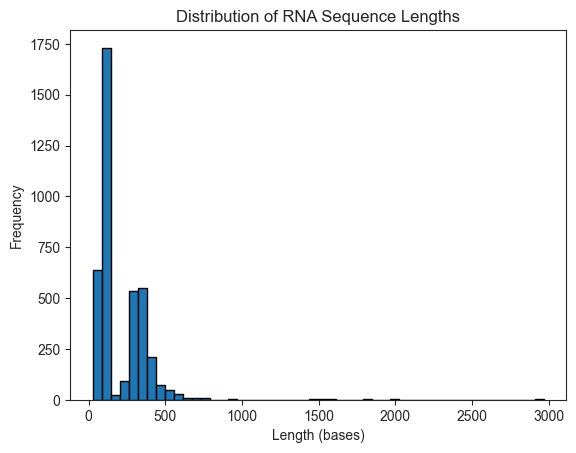

In [21]:
def get_sequence_lengths(ct_files):
    lengths = []
    for file in ct_files:
        rna_seq, _ = parse_ct_file(file)
        lengths.append(len(rna_seq))
    return lengths

def plot_sequence_length_distribution(lengths):
    plt.hist(lengths, bins=50, log=False, edgecolor="black")
    plt.title('Distribution of RNA Sequence Lengths')
    plt.xlabel('Length (bases)')
    plt.ylabel('Frequency')
    plt.show()

lengths = get_sequence_lengths(ct_files)
plot_sequence_length_distribution(lengths)

### What's the distribution of nucleic acid bases?

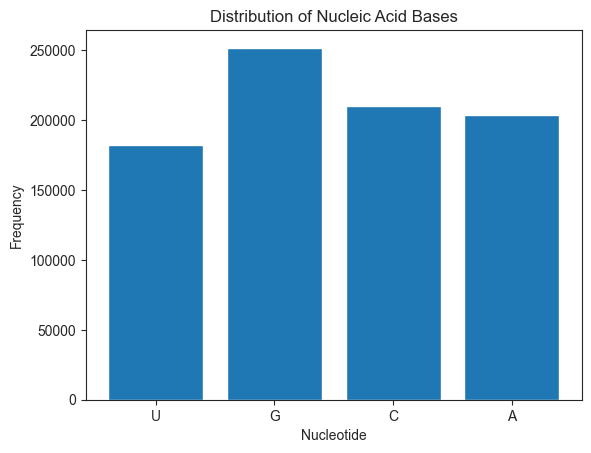

In [45]:
# duplicates?
# average... per sequence
# are there any more questions... how can this data help?

# did I keep the duplicates or not? And why?

def base_distribution(ct_files):
    base_counts = collections.Counter()
    for file in ct_files:
        rna_seq, _ = parse_ct_file(file)
        base_counts.update(rna_seq)
    return base_counts

# know input/output of functions you call

def plot_base_distribution(base_counts):
    plt.bar(base_counts.keys(), base_counts.values())
    plt.title('Distribution of Nucleic Acid Bases')
    plt.xlabel('Nucleotide')
    plt.ylabel('Frequency')
    plt.show()

base_counts = base_distribution(ct_files)
plot_base_distribution(base_counts)

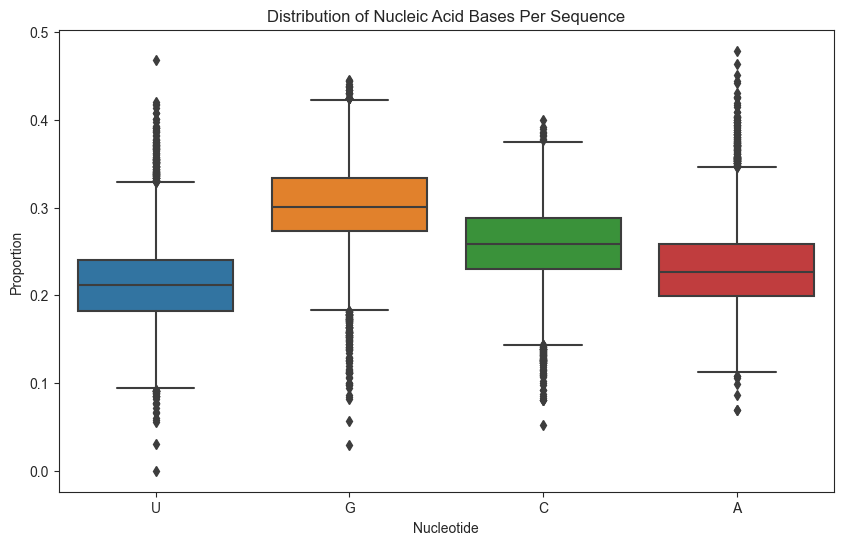

In [44]:
def base_distribution_per_sequence(ct_files):
    base_distributions = []
    for file in ct_files:
        rna_seq, _ = parse_ct_file(file)
        base_counts = collections.Counter(rna_seq)
        total_bases = sum(base_counts.values())
        base_proportions = {base: count / total_bases for base, count in base_counts.items()}
        base_distributions.append(base_proportions)
    return base_distributions

def plot_base_distribution_per_sequence(base_distributions):
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(base_distributions).fillna(0)
    
    # Melt the DataFrame for easier plotting
    df_melted = df.melt(var_name='Base', value_name='Proportion')
    
    # Plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Base', y='Proportion', data=df_melted)
    plt.title('Distribution of Nucleic Acid Bases Per Sequence')
    plt.xlabel('Nucleotide')
    plt.ylabel('Proportion')
    plt.show()

# Calculate base distribution per sequence
base_distributions = base_distribution_per_sequence(ct_files)

# Plot the distribution
plot_base_distribution_per_sequence(base_distributions)

In [48]:
def find_non_standard_bases(ct_files):
    standard_bases = set("ACUG")
    non_standard = collections.Counter()
    for file in ct_files:
        rna_seq, _ = parse_ct_file(file)
        for base in rna_seq:
            if base not in standard_bases:
                non_standard[base] += 1
    return non_standard

# Example usage
non_standard_bases = find_non_standard_bases(ct_files)
print(f"Non-standard bases: {non_standard_bases}")

Non-standard bases: Counter()


In [50]:
def count_base_pairs(ct_files):
    """
    Counts the occurrences of each type of base pairing in the given CT files.

    Parameters:
        ct_files (list): List of paths to CT files.

    Returns:
        collections.Counter: A counter object with the counts of each base pairing.
    """
    pair_counts = collections.Counter()
    for file in ct_files:
        sequence = []
        raw_pairlist = []

        with open(file, 'r') as f:
            for i, line in enumerate(f):
                if i == 0:
                    continue  # Skip the header line
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                n = int(parts[0]) - 1  # nucleotide index (0-based)
                k = int(parts[4]) - 1  # base-pairing partner index (0-based)
                if k >= 0:
                    raw_pairlist.append((n, k))
                sequence.append(parts[1])

        # Deduplicate pairlist
        pairlist = []
        seen = set()
        for pair in raw_pairlist:
            sorted_pair = tuple(sorted(pair))
            if sorted_pair not in seen:
                seen.add(sorted_pair)
                pairlist.append(sorted_pair)

        # Count base pairs
        for start, end in pairlist:
            if start < len(sequence) and end < len(sequence):
                pair = (sequence[start], sequence[end])
                pair_counts[pair] += 1

    return pair_counts

# Calculate the base pair distribution
pair_counts = count_base_pairs(ct_files)

# Display the base pair distribution
print(f"Base pair distribution: {pair_counts}")

Base pair distribution: Counter({('G', 'C'): 72259, ('C', 'G'): 65834, ('U', 'A'): 34331, ('A', 'U'): 31734, ('U', 'G'): 15895, ('G', 'U'): 15023})


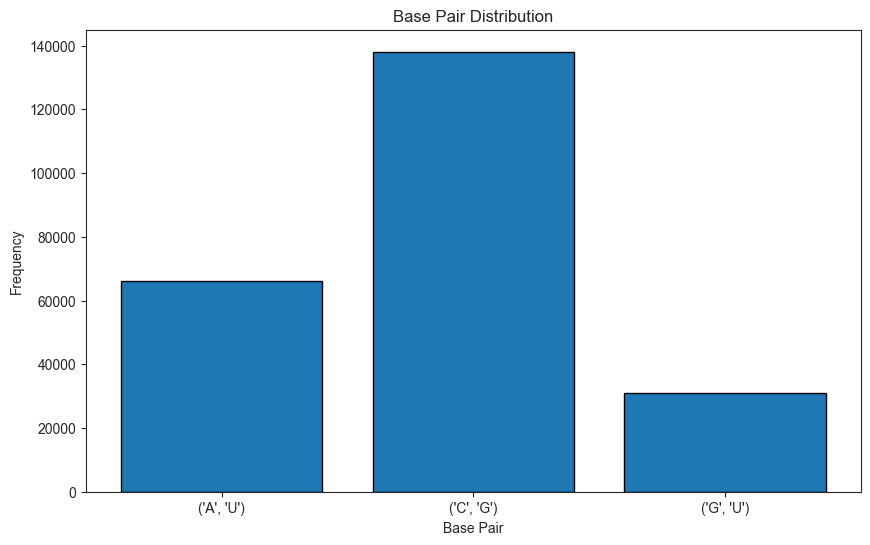

In [56]:
def plot_base_pair_distribution(pair_counts):
    # Convert the counter to a dictionary for easier plotting
    pair_counts_dict = {str(k): v for k, v in pair_counts.items()}
    
    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(pair_counts_dict.keys(), pair_counts_dict.values(), edgecolor="black")
    plt.title('Base Pair Distribution')
    plt.xlabel('Base Pair')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.show()

# Plot the base pair distribution
plot_base_pair_distribution(pair_counts)

Base pair distribution: {('A', 'U'): 66065, ('C', 'G'): 138093, ('G', 'U'): 30918}


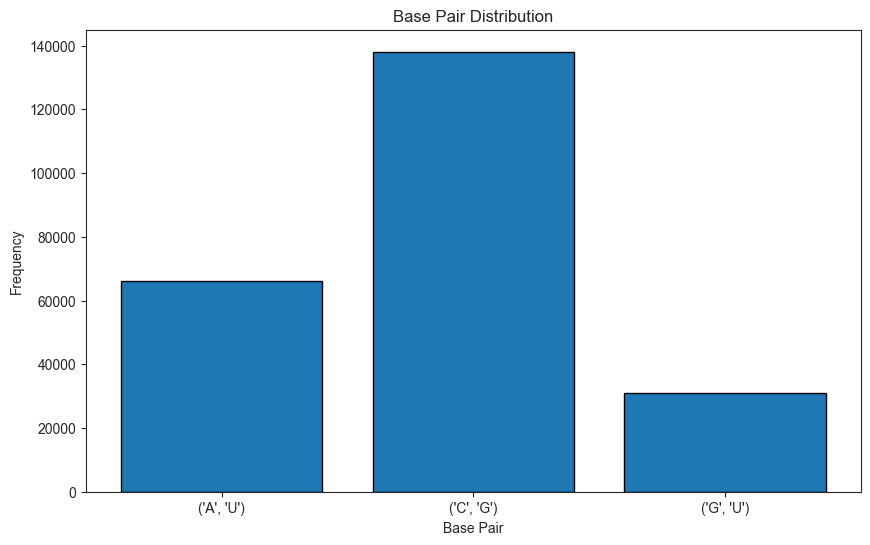

In [61]:
def count_base_pairs(ct_files):
    """
    Counts the occurrences of each type of base pairing in the given CT files,
    treating complementary pairs as the same.

    Parameters:
        ct_files (list): List of paths to CT files.

    Returns:
        collections.Counter: A counter object with the counts of each base pairing.
    """
    pair_counts = collections.Counter()
    for file in ct_files:
        sequence = []
        raw_pairlist = []

        with open(file, 'r') as f:
            for i, line in enumerate(f):
                if i == 0:
                    continue  # Skip the header line
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                n = int(parts[0]) - 1  # nucleotide index (0-based)
                k = int(parts[4]) - 1  # base-pairing partner index (0-based)
                if k >= 0:
                    raw_pairlist.append((n, k))
                sequence.append(parts[1])

        # Deduplicate pairlist
        pairlist = []
        seen = set()
        for pair in raw_pairlist:
            sorted_pair = tuple(sorted(pair))
            if sorted_pair not in seen:
                seen.add(sorted_pair)
                pairlist.append(sorted_pair)

        # Count base pairs, treating complementary pairs as the same
        for start, end in pairlist:
            if start < len(sequence) and end < len(sequence):
                pair = (sequence[start], sequence[end])
                # Sort the pair to treat complementary pairs as the same
                sorted_pair = tuple(sorted(pair))
                pair_counts[sorted_pair] += 1

    return pair_counts

# Calculate the base pair distribution
pair_counts = count_base_pairs(ct_files)

# Display the base pair distribution
print(f"Base pair distribution: {dict(pair_counts)}")
plot_base_pair_distribution(pair_counts)

We can see that RNA base pairing do not have to follow the Watson-Crick order. G--U base pairs are quite common in RNAs because two hydrogen bonds can be formed.

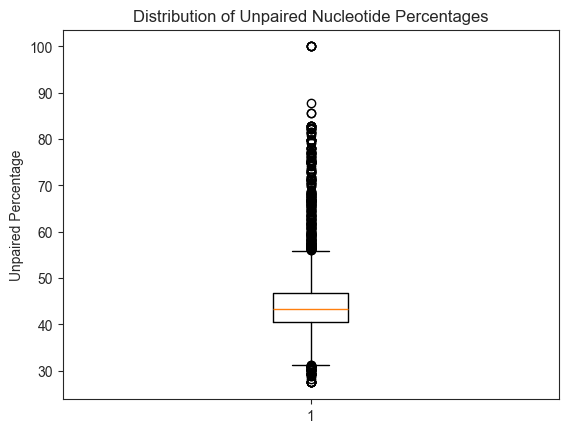

In [57]:
def calculate_unpaired_percentage(ct_files):
    unpaired_percentages = []
    for file in ct_files:
        _, dbn = parse_ct_file(file)
        unpaired_count = dbn.count('.')
        unpaired_percentage = (unpaired_count / len(dbn)) * 100
        unpaired_percentages.append(unpaired_percentage)
    return unpaired_percentages

def plot_unpaired_percentage(unpaired_percentages):
    plt.boxplot(unpaired_percentages)
    plt.title('Distribution of Unpaired Nucleotide Percentages')
    plt.ylabel('Unpaired Percentage')
    plt.show()

# Example usage
unpaired_percentages = calculate_unpaired_percentage(ct_files)
plot_unpaired_percentage(unpaired_percentages)

In [58]:
def count_unpaired_structures(ct_files):
    unpaired_structures = 0
    for file in ct_files:
        _, dbn = parse_ct_file(file)
        if '(' not in dbn and ')' not in dbn:
            unpaired_structures += 1
    return unpaired_structures

# Example usage
unpaired_structures = count_unpaired_structures(ct_files)
print(f"Number of structures without pairings: {unpaired_structures}")

# TODO: take note, you haven't remove the duplicates yet

Number of structures without pairings: 5


In [59]:

def count_pseudoknots(ct_files):
    pseudoknot_structures = 0
    for file in ct_files:
        _, dbn = parse_ct_file(file)
        if any(x in dbn for x in "[]{}<>"):  # Common symbols for pseudoknots
            pseudoknot_structures += 1
    return pseudoknot_structures

# Example usage
pseudoknot_structures = count_pseudoknots(ct_files)
print(f"Number of structures with pseudoknots: {pseudoknot_structures}")

Number of structures with pseudoknots: 1086
